## Imports





In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.decomposition import PCA

## Selecionando a base de dados

In [ ]:
datashet = pd.read_csv('winequalityN.csv')
## Base de dados que vai ser usada para treino e teste
data = pd.DataFrame(datashet)
## Base de dados que vai ser usada para unferencia
dataOnlyRed = pd.DataFrame(datashet)
## Fazendo o replace dos caracteres indesejados
data.columns = data.columns.str.lower().str.replace(' ','_')
dataOnlyRed.columns = dataOnlyRed.columns.str.lower().str.replace(' ','_')

## Separando as datas com seus tipos

In [ ]:
data = data.query("type != 'red'")
dataOnlyRed = dataOnlyRed.query("type != 'white'")

print(dataOnlyRed['type'].head())
print(data['type'].head())

4898    red
4899    red
4900    red
4901    red
4902    red
Name: type, dtype: object
0    white
1    white
2    white
3    white
4    white
Name: type, dtype: object


## Criando variavel opnion para ambas as datas seguindo a mesma logica


In [ ]:
opinion = data['quality'].apply(lambda x: 1 if x >= 5 else 0)
opinion_red = dataOnlyRed['quality'].apply(lambda x: 1 if x >= 5 else 0)

print('Red: ',opinion_red.value_counts())
print('White',opinion.value_counts())


Red:  quality
1    1536
0      63
Name: count, dtype: int64
White quality
1    4715
0     183
Name: count, dtype: int64


## Começando Analise Exploratória

**Focando inicialmente na data referente aos treinamentos ou seja a variavel data**

In [ ]:
data.head()

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


| Variável                | Tipo          |
|-------------------------|---------------|
| **type**                | Categórica    |
| **fixed_acidity**       | Contínua      |
| **volatile_acidity**    | Contínua      |
| **citric_acid**         | Contínua      |
| **residual_sugar**      | Contínua      |
| **chlorides**           | Contínua      |
| **free_sulfur_dioxide** | Contínua      |
| **total_sulfur_dioxide**| Contínua      |
| **density**             | Contínua      |
| **ph**                  | Contínua      |
| **sulphates**           | Contínua      |
| **alcohol**             | Contínua      |
| **quality**             | Categórica    |

Irei assumir que quality sera uma variavel categorica pois iremos trabalhar com uma logica aplicada de categoria  >= 5 sera 1 e < 5 sera 0



```
opinion = data['quality'].apply(lambda x: 1 if x >= 5 else 0)
```



In [ ]:
data.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
count,4890.000000,4891.000000,4896.000000,4896.000000,4896.000000,4898.000000,4898.000000,4898.000000,4891.000000,4896.000000,4898.000000,4898.000000
mean,6.855532,0.278252,0.334250,6.393250,0.045778,35.308085,138.360657,0.994027,3.188203,0.489835,10.514267,5.877909
std,0.843808,0.100811,0.120985,5.072275,0.021850,17.007137,42.498065,0.002991,0.151014,0.114147,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


## Estamos trabalhando com um dataset desbalanceado

Precisaremos balancer o nosso dataset futuramente para que nosso treinamento seja cabivel

In [ ]:
opinion.value_counts() # contando os valores

,count
quality,
1,4715
0,183


## Definir as features e nosso target

In [ ]:
# Esses parametros serão usados para treinar e testar os modelos
numericas = data.iloc[:,1:] # seleciona todas as colunas menos a type
target = opinion # meu Y
#------------------------------------------------------
# Esses parametros serão usados para fazer a inferencia nos modelos
numericas_red = dataOnlyRed.iloc[:,1:] # seleciona todas as colunas menos a type
target_red = opinion_red # meu Y



## Separação treino e teste

In [ ]:

y = target
x = numericas

# Treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y)



In [ ]:
# Remover as amostras de target_red onde há NaN
target_red = target_red.dropna()
numericas_red = numericas_red.dropna()
# igulandos as amostras
target_red = target_red.loc[numericas_red.index]

In [ ]:
# Criando o dummyModel
dummy_model = DummyClassifier(strategy="most_frequent")

dummy_model.fit(x_train, y_train)

predictions_dumb = dummy_model.predict(y_test)
print(predictions_dumb)
print(classification_report(y_test, predictions_dumb));

[1 1 1 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        55
           1       0.96      1.00      0.98      1415

    accuracy                           0.96      1470
   macro avg       0.48      0.50      0.49      1470
weighted avg       0.93      0.96      0.94      1470



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Modelo de Regrssão Logisca

In [ ]:
# Usei o dorpna para retirar todos os nulos do treinamento e evitar futuros erros
y_train = y_train.dropna()
x_train = x_train.dropna()
# Aqui fiz com que ambos ficassem coma mesma quantidade de  amostras
y_train = y_train.loc[x_train.index]
imputer = SimpleImputer(strategy='mean') # Criando o Imputer para garantir que não ira ter nulos

# Cirando PipeLine
logistic_model = Pipeline([
     ('imputer', imputer),
    ('scaler',MinMaxScaler()),
    ('classifier', LogisticRegression(random_state=42))
])

# Selecionando hiperparâmetros
param_grid_lg = {
    'classifier__C': [ 1, 10,100], # Optei por valores não fracionais no meu C assim aumentando a regularização e evitando overfitting
    'classifier__penalty': ['l1', 'l2'],# U Usei essas penalidades por conta dos meus solvers que suportam ambos
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__max_iter': [100, 200], # Definir Otimização do modelo

}

spliter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)# Configurando spliter

scoring = ['f1', 'precision', 'recall', 'accuracy'] # separei os scores para a busca retirar as metricas e medias para mim calcular

grid_search_lg = GridSearchCV(
    logistic_model,
    param_grid_lg,
    cv=spliter,
    verbose=1,
    n_jobs=-1,
    scoring=scoring, # selecionei todos os scores para retirar media mais tarde
    refit='f1' # Escolhi o F1 por acredito que seja a melhor escolha para bases desbalanceadas
    )
grid_search_lg.fit(x_train, y_train)
# Exibindo os melhores parâmetros e a melhor pontuação
print("Melhores parâmetros:", grid_search_lg.best_params_)
print("Melhor pontuação", grid_search_lg.best_score_)



Fitting 10 folds for each of 24 candidates, totalling 240 fits
Melhores parâmetros: {'classifier__C': 1, 'classifier__max_iter': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Melhor pontuação 1.0


## Retirando as medias

In [ ]:
 # Acessando os resultados da busca em grade
results = grid_search_lg.cv_results_

# Metricas a serem analisadas
metrics = ['f1', 'recall', 'precision', 'accuracy']

# Dicionarios para armazenar a soma das medias e dos desvios
sum_means = {metric: 0 for metric in metrics}
sum_stds = {metric: 0 for metric in metrics}
num_models = len(results['params'])  # Numero total de modelos testados

# Loop para calcular a soma das medias e desvios padrão
for metric in metrics:
    mean_scores = results[f'mean_test_{metric}']  # Media das pontuações da métrica
    std_scores = results[f'std_test_{metric}']    # Desvio padrão das pontuações da métrica

    sum_means[metric] = sum(mean_scores) / num_models
    sum_stds[metric] = sum(std_scores) / num_models

# Exibindo os resultados
total_metrics = "\n".join(
    [f"{metric.upper()} - Média: {sum_means[metric]:.4f}, Desvio Padrão: {sum_stds[metric]:.4f}" for metric in metrics]
)

print("Médias e Desvios Padrão de Todos os Modelos:\n")
print(total_metrics)


Médias e Desvios Padrão de Todos os Modelos:

F1 - Média: 0.9979, Desvio Padrão: 0.0004
RECALL - Média: 1.0000, Desvio Padrão: 0.0000
PRECISION - Média: 0.9958, Desvio Padrão: 0.0009
ACCURACY - Média: 0.9958, Desvio Padrão: 0.0009


In [ ]:
ypred_lg = grid_search_lg.best_estimator_.predict(x_test)
ypred_lg_train = grid_search_lg.best_estimator_.predict(x_train)
ypred_lg_red = grid_search_lg.best_estimator_.predict(numericas_red)
# Base de teste
print('Base de teste',classification_report(y_test, ypred_lg))
print()
# Base de treino
print('Base de treino',classification_report(y_train, ypred_lg_train))
print()
# Base de inferencia
print('Base de inferencia',classification_report(target_red, ypred_lg_red))

Base de teste               precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00      1415

    accuracy                           1.00      1470
   macro avg       1.00      1.00      1.00      1470
weighted avg       1.00      1.00      1.00      1470


Base de treino               precision    recall  f1-score   support

           0       1.00      1.00      1.00       127
           1       1.00      1.00      1.00      3280

    accuracy                           1.00      3407
   macro avg       1.00      1.00      1.00      3407
weighted avg       1.00      1.00      1.00      3407


Base de inferencia               precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00      1531

    accuracy                           1.00      1593
   macro avg       1.00      1.00      1.00      1593
weighted avg       1.00 

## Modelo de Arvore de Decisões

In [ ]:
# Cirando PipeLine
dt_model = Pipeline([
     ('imputer', imputer),
    ('scaler',MinMaxScaler()),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Selecionando hiperparâmetros
param_grid_dt = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [3, 5, 10,], # Defini limites para evitar complexidade
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]

}

spliter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = ['f1', 'precision', 'recall', 'accuracy']
grid_search_dt = GridSearchCV(
    dt_model,
    param_grid_dt,
    cv=spliter,
    verbose=1,
    n_jobs=-1,
    scoring=scoring,
    refit='f1' # Escolhi o F1 por acredito que seja a melhor escolha para bases desbalanceadas
    )
grid_search_dt.fit(x_train, y_train)
# Exibindo os melhores parâmetros e a melhor pontuação
print("Melhores parâmetros:", grid_search_dt.best_params_)
print("Melhor pontuação", grid_search_dt.best_score_)

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Melhores parâmetros: {'classifier__criterion': 'gini', 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Melhor pontuação 1.0


In [ ]:
 # Acessando os resultados da busca em grade
results = grid_search_dt.cv_results_

# Metricas a serem analisadas
metrics = ['f1', 'recall', 'precision', 'accuracy']

# Dicionarios para armazenar a soma das medias e dos desvios
sum_means = {metric: 0 for metric in metrics}
sum_stds = {metric: 0 for metric in metrics}
num_models = len(results['params'])  # Numero total de modelos testados

# Loop para calcular a soma das medias e desvios padrão
for metric in metrics:
    mean_scores = results[f'mean_test_{metric}']  # Media das pontuações da metrica
    std_scores = results[f'std_test_{metric}']    # Desvio padrão das pontuações da metrica

    sum_means[metric] = sum(mean_scores) / num_models
    sum_stds[metric] = sum(std_scores) / num_models

# Exibindo os resultados
total_metrics = "\n".join(
    [f"{metric.upper()} - Média: {sum_means[metric]:.4f}, Desvio Padrão: {sum_stds[metric]:.4f}" for metric in metrics]
)

print("Médias e Desvios Padrão de Todos os Modelos:\n")
print(total_metrics)


Médias e Desvios Padrão de Todos os Modelos:

F1 - Média: 1.0000, Desvio Padrão: 0.0000
RECALL - Média: 1.0000, Desvio Padrão: 0.0000
PRECISION - Média: 1.0000, Desvio Padrão: 0.0000
ACCURACY - Média: 1.0000, Desvio Padrão: 0.0000


In [ ]:


ypred_dt = grid_search_dt.best_estimator_.predict(x_test)
ypred_dt_train = grid_search_dt.best_estimator_.predict(x_train)
ypred_dt_red = grid_search_dt.best_estimator_.predict(numericas_red)
# Base de teste
print('Base de teste',classification_report(y_test, ypred_dt))
print()
# Base de treino
print('Base de treino',classification_report(y_train, ypred_dt_train))
print()
# Base de inferencia
print('Base de inferencia',classification_report(target_red, ypred_dt_red))


Base de teste               precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00      1415

    accuracy                           1.00      1470
   macro avg       1.00      1.00      1.00      1470
weighted avg       1.00      1.00      1.00      1470


Base de treino               precision    recall  f1-score   support

           0       1.00      1.00      1.00       127
           1       1.00      1.00      1.00      3280

    accuracy                           1.00      3407
   macro avg       1.00      1.00      1.00      3407
weighted avg       1.00      1.00      1.00      3407


Base de inferencia               precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00      1531

    accuracy                           1.00      1593
   macro avg       1.00      1.00      1.00      1593
weighted avg       1.00 

## Modelo SVM

In [ ]:
# Cirando PipeLine
svm_model = Pipeline([
     ('imputer', imputer),
    ('scaler',MinMaxScaler()),
    ('classifier', SVC(random_state=42))
])


param_grid_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear'],# Selecionei apenas o linear pois o problema que estamos resolveldo e um problema linear
    'classifier__class_weight': ['balanced'], # Aqui optei por balancear o peso por quanto de ser uma data desbalanceada
    'classifier__gamma': ['scale']
}

spliter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = ['f1', 'precision', 'recall', 'accuracy']
grid_search_svm = GridSearchCV(
    svm_model,
    param_grid_svm,
    cv=spliter,
    verbose=1,
    n_jobs=-1,
    scoring=scoring, # selecionei todos os scores para retirar media mais tarde
    refit='f1' # Escolhi o F1 por acredito que seja a melhor escolha para bases desbalanceadas
    )
grid_search_svm.fit(x_train, y_train)
# Exibindo os melhores parâmetros e a melhor pontuação
print("Melhores parâmetros:", grid_search_svm.best_params_)
print("Melhor pontuação", grid_search_svm.best_score_)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Melhores parâmetros: {'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Melhor pontuação 1.0


In [ ]:
 # Acessando os resultados da busca em grade
results = grid_search_svm.cv_results_

# Metricas a serem analisadas
metrics = ['f1', 'recall', 'precision', 'accuracy']

# Dicionarios para armazenar a soma das medias e dos desvios
sum_means = {metric: 0 for metric in metrics}
sum_stds = {metric: 0 for metric in metrics}
num_models = len(results['params'])  # Numero total de modelos testados

# Loop para calcular a soma das medias e desvios padrão
for metric in metrics:
    mean_scores = results[f'mean_test_{metric}']  # Media das pontuações da metrica
    std_scores = results[f'std_test_{metric}']    # Desvio padrão das pontuações da metrica

    sum_means[metric] = sum(mean_scores) / num_models
    sum_stds[metric] = sum(std_scores) / num_models

# Exibindo os resultados consolidados
total_metrics = "\n".join(
    [f"{metric.upper()} - Média: {sum_means[metric]:.4f}, Desvio Padrão: {sum_stds[metric]:.4f}" for metric in metrics]
)

print("Médias e Desvios Padrão de Todos os Modelos:\n")
print(total_metrics)

Médias e Desvios Padrão de Todos os Modelos:

F1 - Média: 1.0000, Desvio Padrão: 0.0000
RECALL - Média: 1.0000, Desvio Padrão: 0.0000
PRECISION - Média: 1.0000, Desvio Padrão: 0.0000
ACCURACY - Média: 1.0000, Desvio Padrão: 0.0000


In [ ]:
ypred_svm = grid_search_svm.best_estimator_.predict(x_test)
ypred_svm_train = grid_search_svm.best_estimator_.predict(x_train)
ypred_svm_red = grid_search_dt.best_estimator_.predict(numericas_red)
# Base de teste
print('Base de teste',classification_report(y_test, ypred_svm))
print()
# Base de treino
print('Base de treino',classification_report(y_train, ypred_svm_train))
print()
# Base de inferencia
print('Base de inferencia',classification_report(target_red, ypred_svm_red))

Base de teste               precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00      1415

    accuracy                           1.00      1470
   macro avg       1.00      1.00      1.00      1470
weighted avg       1.00      1.00      1.00      1470


Base de treino               precision    recall  f1-score   support

           0       1.00      1.00      1.00       127
           1       1.00      1.00      1.00      3280

    accuracy                           1.00      3407
   macro avg       1.00      1.00      1.00      3407
weighted avg       1.00      1.00      1.00      3407


Base de inferencia               precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00      1531

    accuracy                           1.00      1593
   macro avg       1.00      1.00      1.00      1593
weighted avg       1.00 

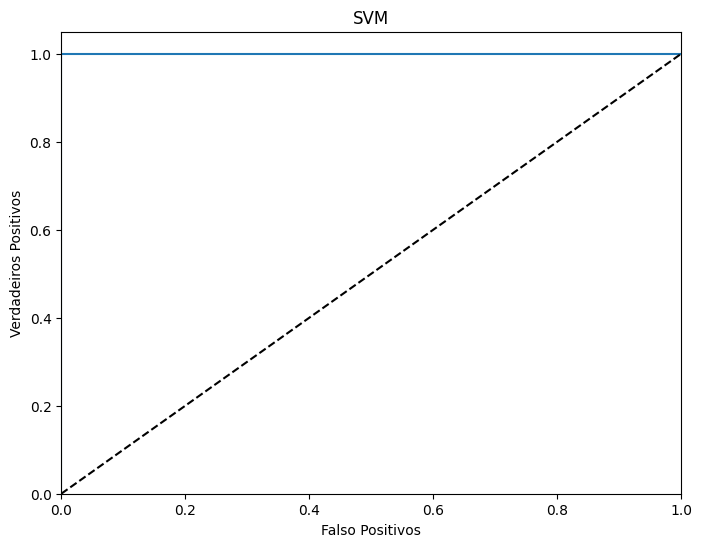

In [ ]:
#MODELO SVM-------------------------------------------------------------------
# Calculando ROC AUC score
roc_auc = roc_auc_score(y_test, grid_search_svm.best_estimator_.decision_function(x_test))

# Calculando ROC curve
fpr, tpr, thresholds = roc_curve(y_test, grid_search_svm.best_estimator_.decision_function(x_test))


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Linha Diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falso Positivos')
plt.ylabel('Verdadeiros Positivos')
plt.title('SVM')
plt.show()
#-----------------------------------------------------------------------------




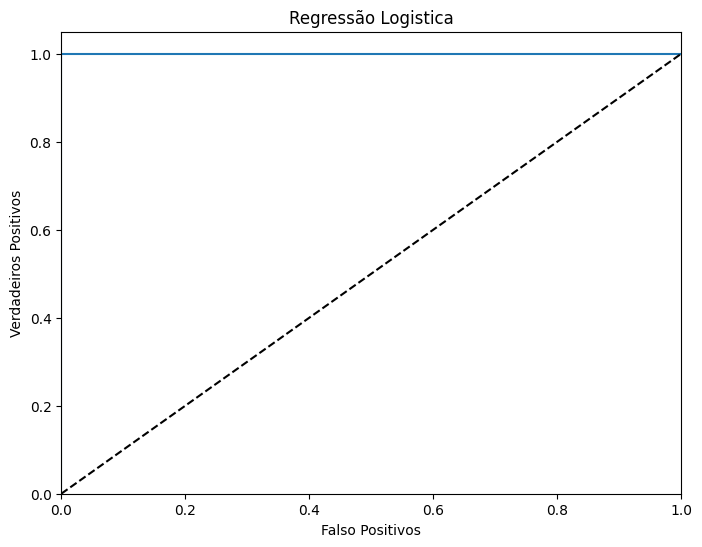

In [ ]:
#MODELO  RegLog-------------------------------------------------------------------
# Calculando ROC AUC score
roc_auc_lg = roc_auc_score(y_test, grid_search_lg.best_estimator_.decision_function(x_test))

# Calculando ROC curve
fpr, tpr, thresholds = roc_curve(y_test, grid_search_lg.best_estimator_.decision_function(x_test))


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc_lg:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Linha Diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falso Positivos')
plt.ylabel('Verdadeiros Positivos')
plt.title('Regressão Logistica')
plt.show()
#-----------------------------------------------------------------------------




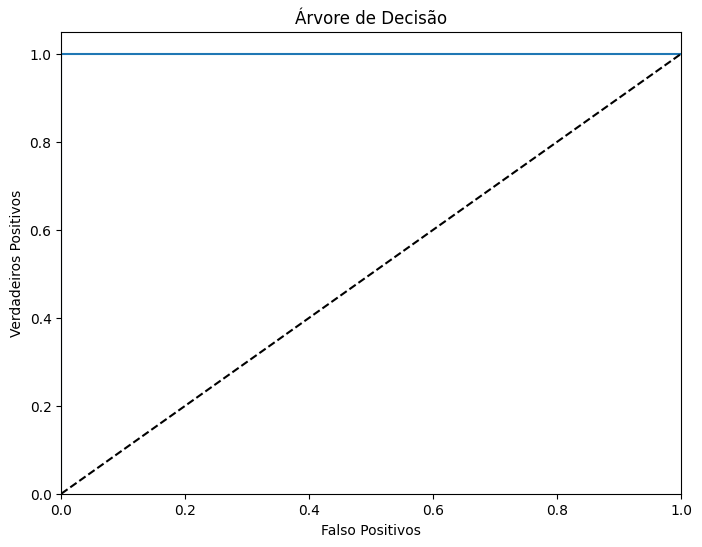

In [ ]:
#MODELO Arvore de Decisões-------------------------------------------------------------------
# Calculando ROC AUC score para o modelo de árvore de decisão
roc_auc_dt = roc_auc_score(y_test, grid_search_dt.best_estimator_.predict_proba(x_test)[:, 1])

# Calculando ROC curve para o modelo de árvore de decisão
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, grid_search_dt.best_estimator_.predict_proba(x_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, label=f'ROC Curve (area = {roc_auc_dt:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Linha Diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falso Positivos')
plt.ylabel('Verdadeiros Positivos')
plt.title('Árvore de Decisão')
plt.show()
#-----------------------------------------------------------------------------

5 -Após analisar as curvas ROC, percebi que não houve uma diferença significativa nos resultados. No entanto, acredito que o modelo com menor complexidade, a Regressão Logística, seja a melhor opção entre os modelos treinados.

6-Executei a inferência em todos os modelos e, levando em consideração que o dataset segue a mesma lógica de pontuação para os vinhos, fiquei satisfeito com o desempenho geral dos modelos. Eles apresentaram resultados bastante consistentes e eficientes.

## Faça o módulo do Kaggle Intro to Machine Learning:

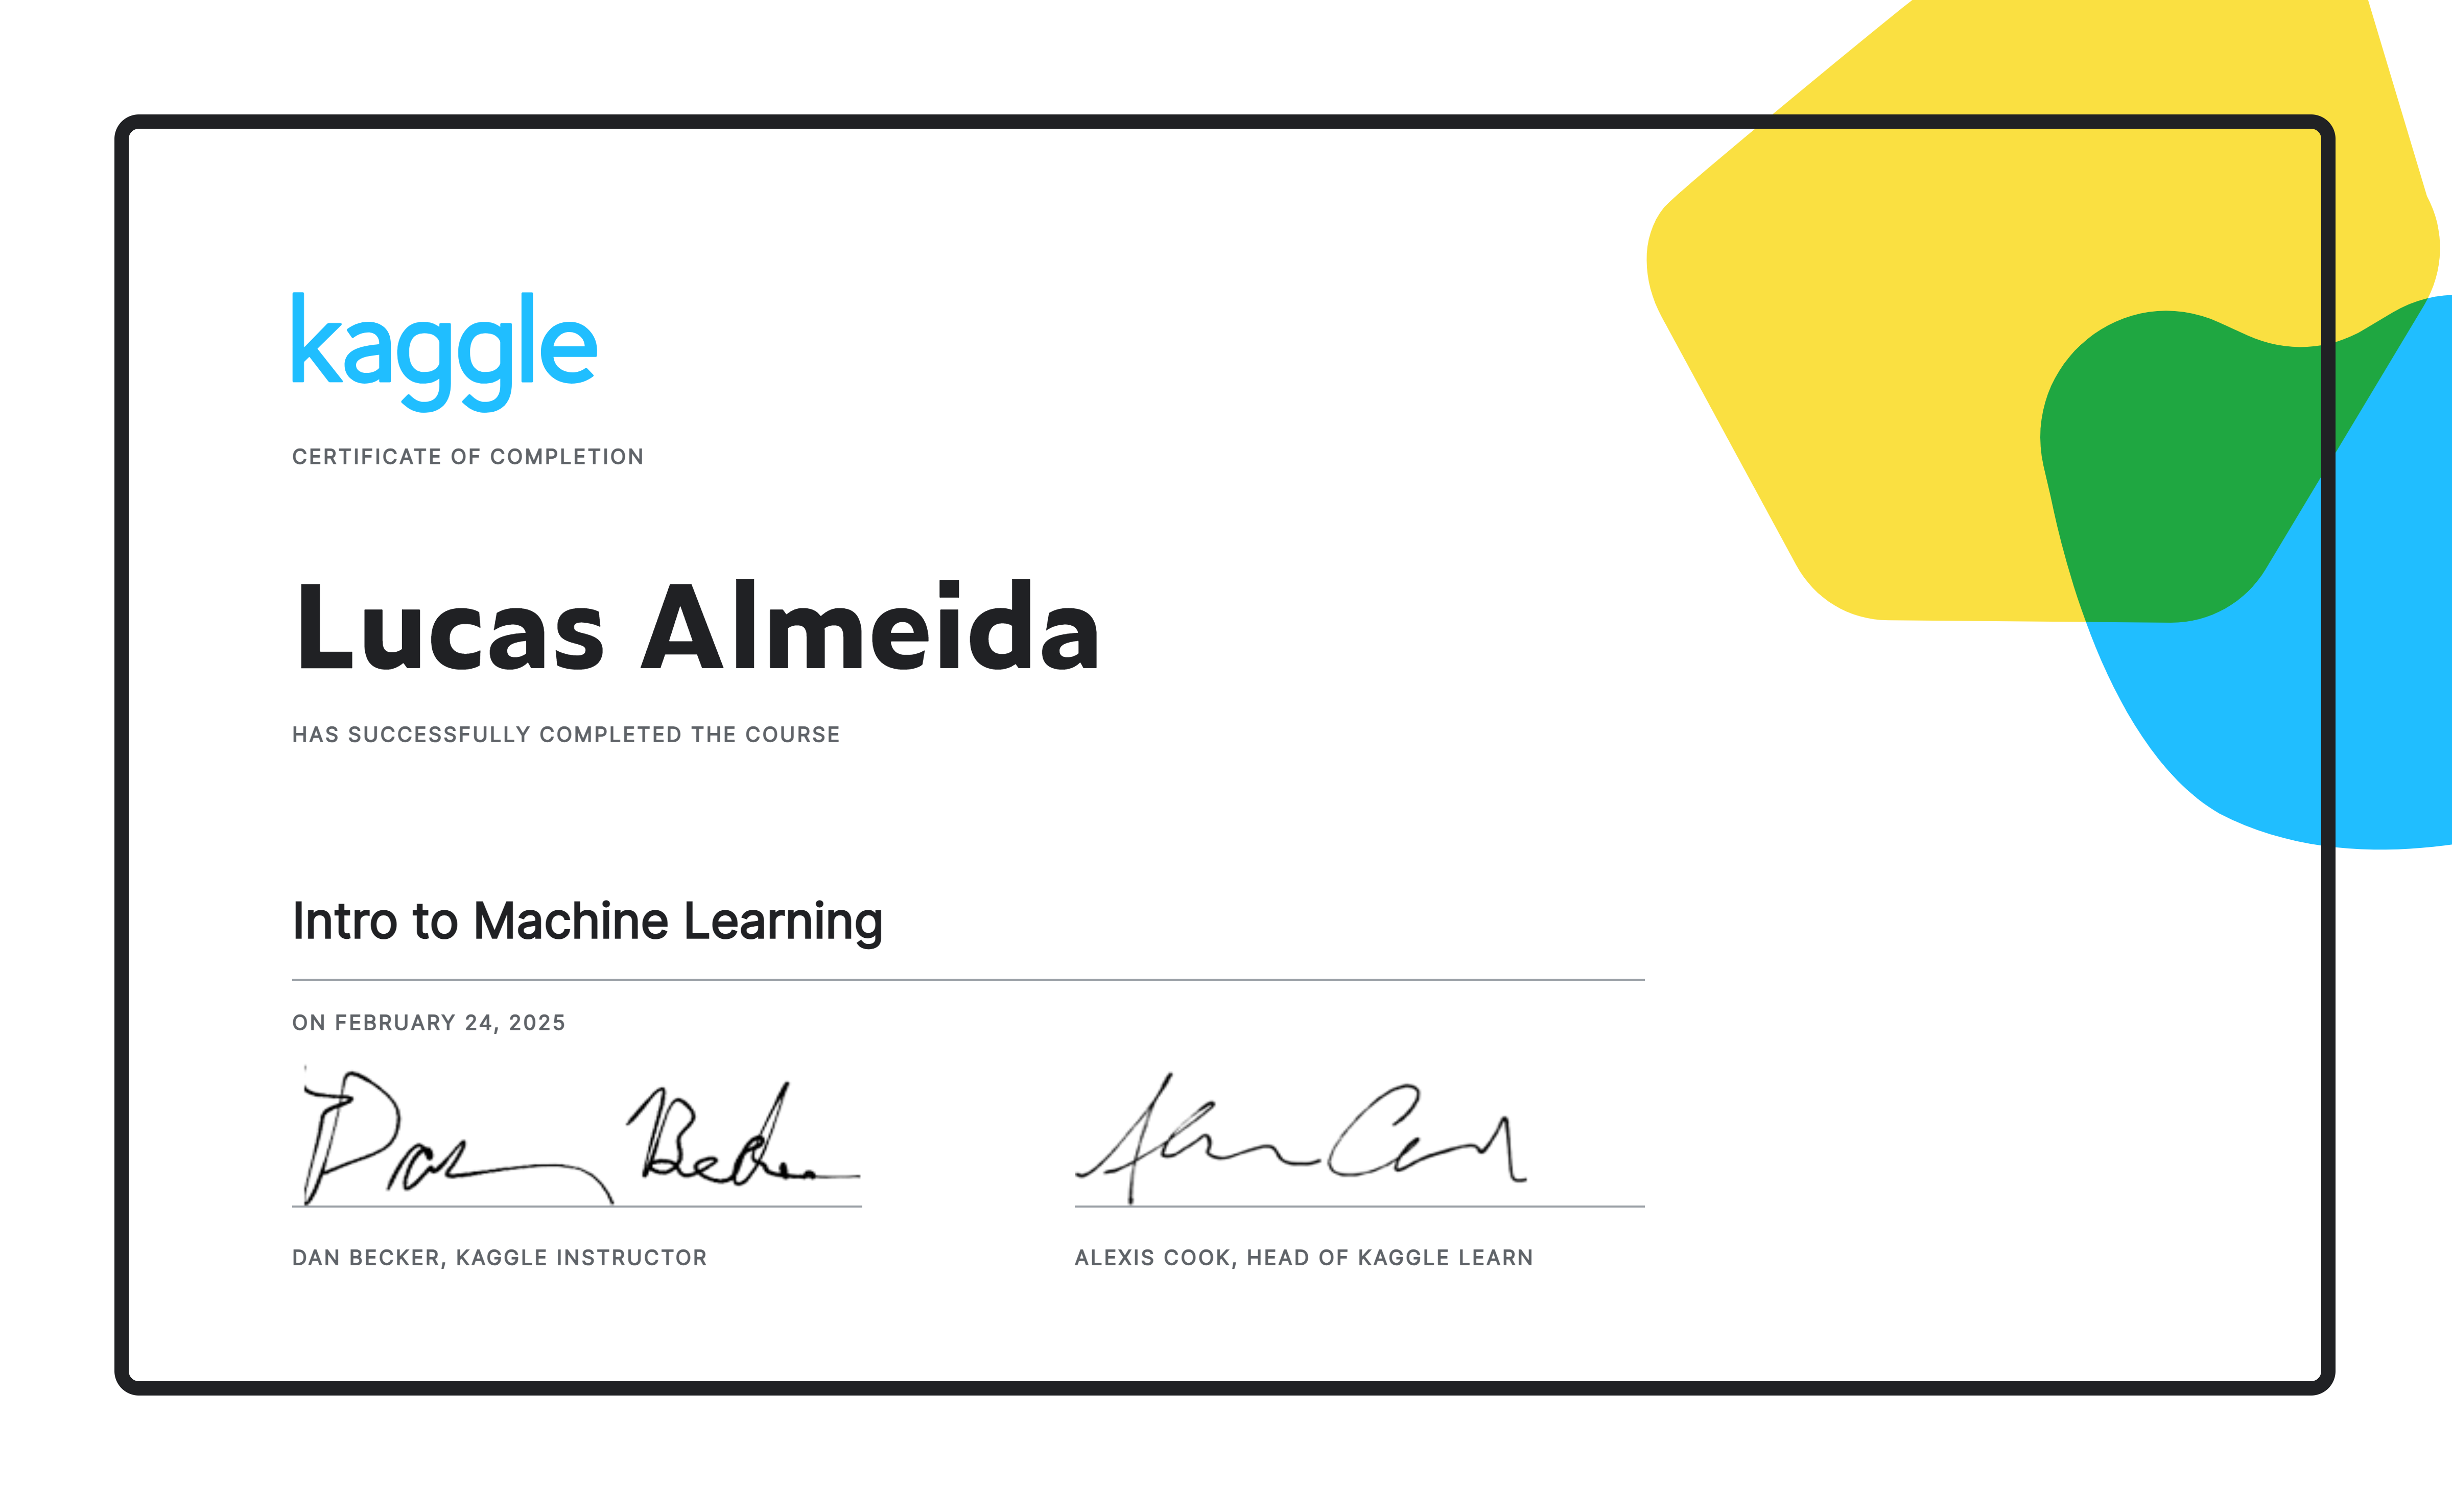